In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.spatial import Voronoi
from shapely.geometry import Point, Polygon
from shapely.ops import unary_union


In [9]:
boroughs

,name,type,station1,station2,geometry
0,Kingston upon Thames,borough,None,None,"POLYGON ((-0.33068 51.32901, -0.33059 51.32909..."
1,Croydon,borough,None,None,"POLYGON ((-0.06402 51.31864, -0.06408 51.31861..."
2,Bromley,borough,None,None,"POLYGON ((0.01213 51.2996, 0.01196 51.2998, 0...."
3,Hounslow,borough,None,None,"POLYGON ((-0.24456 51.4887, -0.24468 51.48868,..."
4,Ealing,borough,None,None,"POLYGON ((-0.41183 51.53408, -0.41188 51.53412..."
...,...,...,...,...,...
565,None,line,Euston,Warren Street,"LINESTRING (-0.1333 51.52866, -0.13828 51.52458)"
566,None,line,West Finchley,Woodside Park,"LINESTRING (-0.18892 51.60926, -0.18543 51.61787)"
567,None,line,Angel,King's Cross St. Pancras,"LINESTRING (-0.10558 51.53297, -0.12387 51.53031)"
568,None,line,Chigwell,Grange Hill,"LINESTRING (0.07618 51.61786, 0.09227 51.61348)"


In [8]:
# Filter subway stations (point geometries)
stations_gdf = london_gdf[london_gdf["type"] == "station"].copy()

stations_gdf.head(15)

,name,type,station1,station2,geometry
33,Acton Town,station,None,None,POINT (-0.2803 51.50307)
34,Aldgate,station,None,None,POINT (-0.07563 51.51434)
35,Aldgate East,station,None,None,POINT (-0.073 51.51508)
36,Alperton,station,None,None,POINT (-0.29952 51.54121)
37,Angel,station,None,None,POINT (-0.10558 51.53297)
38,Archway,station,None,None,POINT (-0.13512 51.56549)
39,Arnos Grove,station,None,None,POINT (-0.13427 51.61623)
40,Arsenal,station,None,None,POINT (-0.1055 51.55854)
41,Baker Street,station,None,None,POINT (-0.1569 51.52313)
42,Balham,station,None,None,POINT (-0.15269 51.44318)


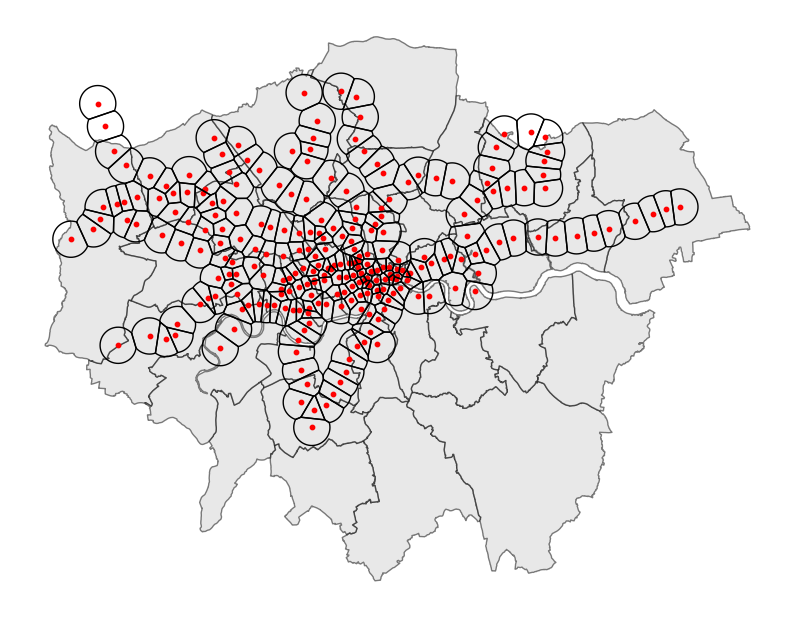

In [4]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.spatial import Voronoi
from shapely.geometry import Point, Polygon
from shapely.ops import unary_union

# Load London boroughs and transport network
london_gdf = gpd.read_file("Complete London Shapefile.gpkg", layer="Combined_London_Data")

# Filter boroughs (polygons)
boroughs = london_gdf[london_gdf["type"] == "borough"].copy()

# Filter subway stations (point geometries)
stations_gdf = london_gdf[london_gdf["type"] == "station"].copy()

# Ensure CRS is EPSG:4326 before converting
boroughs = boroughs.to_crs(epsg=4326)
stations_gdf = stations_gdf.to_crs(epsg=4326)

# Convert to projected CRS (meters) for Voronoi computation
boroughs = boroughs.to_crs(epsg=27700)  # British National Grid
stations_gdf = stations_gdf.to_crs(epsg=27700)

# Extract station coordinates
points = np.array(list(zip(stations_gdf.geometry.x, stations_gdf.geometry.y)))

# Ensure at least 4 points for Voronoi computation
if len(points) < 4:
    raise ValueError("Not enough station points to compute Voronoi diagram.")

# Add artificial boundary points for stability
min_x, min_y, max_x, max_y = stations_gdf.total_bounds
boundary_points = np.array([
    [min_x - 1000, min_y - 1000], 
    [min_x - 1000, max_y + 2000], 
    [max_x + 1000, min_y - 1000], 
    [max_x + 1000, max_y + 2000]
])
points = np.vstack([points, boundary_points])

# Compute Voronoi diagram
vor = Voronoi(points)

# Define buffer area around stations (1.5 km radius)
max_distance_m = 1500  
station_buffers = stations_gdf.geometry.buffer(max_distance_m)
valid_area = unary_union(station_buffers)

# Build clipped Voronoi polygons and track names
clipped_polygons = []
station_names = []

for point_idx, region_idx in enumerate(vor.point_region):
    if point_idx >= len(stations_gdf):  # skip artificial boundary points
        continue
    
    region = vor.regions[region_idx]
    if not region or -1 in region:
        continue

    polygon = Polygon([vor.vertices[i] for i in region])
    clipped_polygon = polygon.intersection(valid_area)

    if not clipped_polygon.is_empty and clipped_polygon.is_valid:
        clipped_polygons.append(clipped_polygon)
        station_names.append(stations_gdf.iloc[point_idx]["name"])

# Create GeoDataFrame
voronoi_gdf = gpd.GeoDataFrame({"name": station_names}, geometry=clipped_polygons, crs="EPSG:27700")

# Save if needed
# voronoi_gdf.to_file("London_Voronoi_File_1_5km.shp")

# Plot for verification
fig, ax = plt.subplots(figsize=(10, 10))
boroughs.plot(ax=ax, color="lightgrey", edgecolor="black", alpha=0.5)
voronoi_gdf.boundary.plot(ax=ax, edgecolor="black", linewidth=1)
stations_gdf.plot(ax=ax, color="red", markersize=10, label="Stations")

ax.set_axis_off()
plt.show()


In [13]:
voronoi_gdf.head(15)

,name,geometry
0,Acton Town,"POLYGON ((520669.855 179888.831, 519800.047 17..."
1,Aldgate,"POLYGON ((533552.868 181633.216, 533865.073 18..."
2,Aldgate East,"POLYGON ((533844.691 182353.341, 534822.478 18..."
3,Alperton,"POLYGON ((518964.936 183508.965, 517445.175 18..."
4,Angel,"POLYGON ((531016.653 182521.727, 530665.305 18..."
5,Archway,"POLYGON ((530361.763 186393.34, 530178.317 186..."
6,Arnos Grove,"POLYGON ((528525.808 191169.419, 528525.357 19..."
7,Arsenal,"POLYGON ((531611.864 185450.075, 530400.435 18..."
8,Baker Street,"POLYGON ((528188.356 181543.367, 527830.835 18..."
9,Balham,"POLYGON ((527009.463 173478.484, 527010.82 173..."


In [14]:
# Ensure the Voronoi GeoDataFrame is in the original CRS before saving
# voronoi_gdf = voronoi_gdf.to_crs(original_crs)

# Define output file path
output_path = "London_Voronoi_File_1_5km.shp"

# Save the Voronoi polygons as a Shapefile
voronoi_gdf.to_file(output_path, driver="ESRI Shapefile")

print(f"Voronoi diagram saved to {output_path}")

Voronoi diagram saved to London_Voronoi_File_1_5km.shp
